# Student grade

#### Name: 沈家駿
#### Student ID: 0712223

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

## Data Input
I analyze the math dataset.

In [2]:
df = pd.read_csv('student-mat.csv', delimiter=';')

In [3]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


## Data Preprocessing
### Divide the data into X(features) and y(labels).

In [4]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

### Transform categorical features into one-hot representation.

In [5]:
X = pd.get_dummies(X)
features_dummies = X.columns
X = X.to_numpy()
X

array([[18,  4,  4, ...,  0,  1,  0],
       [17,  1,  1, ...,  1,  1,  0],
       [15,  1,  1, ...,  1,  1,  0],
       ...,
       [21,  1,  1, ...,  0,  1,  0],
       [18,  3,  2, ...,  1,  1,  0],
       [19,  1,  1, ...,  1,  1,  0]], dtype=int64)

In [6]:
# X_categorical = X.select_dtypes(include = ['object']).columns.values
# print(X_categorical)
# X_numerical = X.select_dtypes(include = ['float64', 'int64']).columns.values
# print(X_numerical)
# assert len(X_categorical)+len(X_numerical) == 32

In [7]:
features_dummies

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'school_GP', 'school_MS', 'sex_F', 'sex_M', 'address_R', 'address_U',
       'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Mjob_at_home',
       'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
       'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services',
       'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other',
       'reason_reputation', 'guardian_father', 'guardian_mother',
       'guardian_other', 'schoolsup_no', 'schoolsup_yes', 'famsup_no',
       'famsup_yes', 'paid_no', 'paid_yes', 'activities_no', 'activities_yes',
       'nursery_no', 'nursery_yes', 'higher_no', 'higher_yes', 'internet_no',
       'internet_yes', 'romantic_no', 'romantic_yes'],
      dtype='object')

### Transform the lable(y) into 2 kind of encoding.
#### Binary classification 

In [8]:
y_binary = (y>=10).astype(int) # 0: < 10  1: >= 10

#### 5-Level classification

In [9]:
def level_stratify(score):
    if score >= 16:
        return 1
    elif score >= 14:
        return 2
    elif score >= 12:
        return 3
    elif score >= 10:
        return 4
    else:
        return 5
y_level = pd.Series(list(map(level_stratify, list(y))))

In [10]:
[(y_level==i).sum() for i in range(1,6)]

[40, 60, 62, 103, 130]

## Run

### Define a function to execute fit, predict and calculate statistical results

In [11]:
def run_model(model, y_, num_class, k=3, need_pca=False, need_std=False, need_print_tree=False):
    ''' Run the model and output the metrics.
    '''
    kf = KFold(n_splits=k, shuffle = True)
    confusionMatrixSum = np.zeros([num_class, num_class])
    accuracySum = 0
    precisionSum = np.zeros([num_class])
    recallSum = np.zeros([num_class])

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_[train_index], y_[test_index]
        
        if need_std:
            transfer = StandardScaler()
            X_train = transfer.fit_transform(X_train)
            X_test = transfer.transform(X_test)
        
        if need_pca:
            pca = PCA(n_components='mle')
            pca.fit(X_train)
            X_train = pca.transform(X_train)
            X_test = pca.transform(X_test)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        conf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred).transpose()
        confusionMatrixSum += np.array(conf_matrix)

        accuracySum += sklearn.metrics.accuracy_score(y_test, y_pred)

        precision_temp, recall_temp, _, _ = sklearn.metrics.precision_recall_fscore_support(y_test, y_pred)
        precisionSum += np.array(precision_temp)
        recallSum += np.array(recall_temp)
    cm = confusionMatrixSum/k
    acc = accuracySum/k
    pc = precisionSum/k
    recall = recallSum/k
    
    return cm, acc, pc, recall

### Define the row and column names of confussion matrices.

In [12]:
lable_binary = ['Fail', 'Pass']
cm_row_binary = list(map(lambda x: 'Predicted '+x, list(lable_binary)))
cm_col_binary = list(map(lambda x: 'Actual '+x, list(lable_binary)))

lable_level = ['I', 'II', 'III', 'IV', 'V']
cm_row_level = list(map(lambda x: 'Predicted '+x, list(lable_level)))
cm_col_level = list(map(lambda x: 'Actual '+x, list(lable_level)))

### Define a function to show the metrics

In [13]:
def show_metrics(metrics):
    cm, acc, pc, recall = metrics
    num_classes = pc.size
    cm_col = cm_col_binary if num_classes == 2 else cm_col_level
    cm_row = cm_row_binary if num_classes == 2 else cm_row_level
    lable = lable_binary if num_classes == 2 else lable_level
    
    display(pd.DataFrame(cm, index=cm_row, columns=cm_col))
    display(pd.DataFrame([acc], index=['Accuracy'], columns=['Avg.']))
    display(pd.DataFrame(pc.reshape(1, num_classes), index=['Precision'], columns=lable))
    display(pd.DataFrame(recall.reshape(1, num_classes), index=['Recall'], columns=lable))

### Random Forest
There are 6 model.
1. Without pca + 5-level
2. Without pca + binary
3. With pca + 5-level
4. With pca + binary (The number of trees=3)
5. With pca + binary (The number of trees=7)
6. With pca + binary (The number of trees=15)

- The difference between K-fold cross-validation and Random Forest
    - From the functional point of view
        - K-fold cross-validation is a stable way to check the performance of a model. In this case, you can check the performances of random forests with different number of trees(or other hyperparameters).
        - Random Forest is a kind of model.
    - From the way of selecting data
        - K-fold cross-validation split data into several(say k) part randomly, and use k-1 parts of data as train data each time(total k times), and a sample will be used k-1 times since a sample will only be used as test data once.
        - If the data selection method of Random Forest is "randomly select samples", it randomly select smples with replacement for each estimator(A sample is selected an unlimited number of times).

#### Without pca + 5-level

In [14]:
cf = RandomForestClassifier()
show_metrics(run_model(model=cf, y_=y_level, num_class=5))

,Actual I,Actual II,Actual III,Actual IV,Actual V
Predicted I,7.000000,2.333333,0.000000,0.000000,0.000000
Predicted II,5.333333,12.666667,2.000000,0.666667,0.000000
Predicted III,1.000000,3.000000,9.000000,4.333333,0.000000
Predicted IV,0.000000,2.000000,9.666667,21.666667,5.333333
Predicted V,0.000000,0.000000,0.000000,7.666667,38.000000


,Avg.
Accuracy,0.670888


,I,II,III,IV,V
Precision,0.791667,0.610504,0.519608,0.562996,0.834127


,I,II,III,IV,V
Recall,0.5,0.636404,0.437116,0.639469,0.877581


#### Without pca + binary

In [15]:
cf = RandomForestClassifier()
show_metrics(run_model(model=cf, y_=y_binary, num_class=2))

,Actual Fail,Actual Pass
Predicted Fail,38.333333,5.666667
Predicted Pass,5.000000,82.666667


,Avg.
Accuracy,0.91898


,Fail,Pass
Precision,0.860956,0.942352


,Fail,Pass
Recall,0.883112,0.939203


#### With pca + 5-level

In [16]:
cf = RandomForestClassifier()
show_metrics(run_model(model=cf, y_=y_level, num_class=5, need_pca=True))

,Actual I,Actual II,Actual III,Actual IV,Actual V
Predicted I,5.333333,4.000000,0.333333,0.000000,0.000000
Predicted II,7.000000,12.333333,3.333333,0.333333,0.000000
Predicted III,0.666667,2.000000,8.000000,2.333333,0.000000
Predicted IV,0.333333,1.666667,8.000000,19.666667,4.000000
Predicted V,0.000000,0.000000,1.000000,12.000000,39.333333


,Avg.
Accuracy,0.642879


,I,II,III,IV,V
Precision,0.548148,0.536345,0.605429,0.588612,0.752405


,I,II,III,IV,V
Recall,0.398793,0.602778,0.417298,0.569408,0.905746


#### With pca + binary (The number of trees=3)

In [17]:
cf = RandomForestClassifier(max_depth=5, random_state=1, n_estimators=3)
show_metrics(run_model(model=cf, y_=y_binary, num_class=2, need_pca=True))

,Actual Fail,Actual Pass
Predicted Fail,16.333333,9.000000
Predicted Pass,27.000000,79.333333


,Avg.
Accuracy,0.726675


,Fail,Pass
Precision,0.629851,0.747577


,Fail,Pass
Recall,0.378014,0.898191


#### With pca + binary (The number of trees=7)

In [18]:
cf = RandomForestClassifier(max_depth=5, random_state=1, n_estimators=7)
show_metrics(run_model(model=cf, y_=y_binary, num_class=2, need_pca=True))

,Actual Fail,Actual Pass
Predicted Fail,27.000000,6.333333
Predicted Pass,16.333333,82.000000


,Avg.
Accuracy,0.827955


,Fail,Pass
Precision,0.80888,0.836707


,Fail,Pass
Recall,0.635618,0.928503


#### With pca + binary (The number of trees=15)

In [19]:
cf = RandomForestClassifier(max_depth=5, random_state=1, n_estimators=15)
show_metrics(run_model(model=cf, y_=y_binary, num_class=2, need_pca=True))

,Actual Fail,Actual Pass
Predicted Fail,33.000000,6.333333
Predicted Pass,10.333333,82.000000


,Avg.
Accuracy,0.87339


,Fail,Pass
Precision,0.839175,0.888054


,Fail,Pass
Recall,0.762237,0.928452


From the last 3 results(3, 7 and 15 trees), we know that the more trees, the higher the accuracy. 

### Decision Tree
There are 6 model.
1. Without PCA + binary
2. Without PCA + 5-level
3. With PCA + 5-level
4. With PCA + binary

#### Without PCA + binary

In [20]:
decisionTree = DecisionTreeClassifier(max_depth=5)
show_metrics(run_model(model=decisionTree, y_=y_binary, num_class=2))

,Actual Fail,Actual Pass
Predicted Fail,34.333333,6.666667
Predicted Pass,9.000000,81.666667


,Avg.
Accuracy,0.881005


,Fail,Pass
Precision,0.843616,0.901407


,Fail,Pass
Recall,0.79465,0.925122


#### Without PCA + 5-level

In [21]:
decisionTree = DecisionTreeClassifier(max_depth=5)
show_metrics(run_model(model=decisionTree, y_=y_level, num_class=5))

,Actual I,Actual II,Actual III,Actual IV,Actual V
Predicted I,8.666667,2.333333,0.333333,0.000000,0.000000
Predicted II,4.666667,14.333333,2.000000,0.000000,0.000000
Predicted III,0.000000,3.333333,13.333333,5.333333,0.000000
Predicted IV,0.000000,0.000000,5.000000,20.333333,9.333333
Predicted V,0.000000,0.000000,0.000000,8.666667,34.000000


,Avg.
Accuracy,0.6887


,I,II,III,IV,V
Precision,0.805861,0.676329,0.622979,0.589506,0.801852


,I,II,III,IV,V
Recall,0.651078,0.708678,0.650966,0.585586,0.782795


#### With PCA + binary

In [22]:
decisionTree = DecisionTreeClassifier(max_depth=4)
show_metrics(run_model(model=decisionTree, y_=y_binary, num_class=2, need_pca=True))

,Actual Fail,Actual Pass
Predicted Fail,34.666667,9.666667
Predicted Pass,8.666667,78.666667


,Avg.
Accuracy,0.860764


,Fail,Pass
Precision,0.783367,0.900836


,Fail,Pass
Recall,0.800692,0.890556


#### With PCA + 5-level

In [23]:
decisionTree = DecisionTreeClassifier(max_depth=4)
show_metrics(run_model(model=decisionTree, y_=y_level, num_class=5, need_pca=True))

,Actual I,Actual II,Actual III,Actual IV,Actual V
Predicted I,8.666667,2.333333,0.666667,0.000000,0.000000
Predicted II,4.666667,10.333333,3.666667,0.333333,0.000000
Predicted III,0.000000,6.666667,10.666667,9.000000,0.333333
Predicted IV,0.000000,0.666667,5.333333,18.333333,9.333333
Predicted V,0.000000,0.000000,0.333333,6.666667,33.666667


,Avg.
Accuracy,0.620325


,I,II,III,IV,V
Precision,0.801587,0.53824,0.406327,0.543109,0.827288


,I,II,III,IV,V
Recall,0.603175,0.512759,0.503527,0.534407,0.781129


### KNN
There are 6 resluts.
1. With pca + 5-level
2. With pca + binary
3. Without pca + 5-level
4. Without pca + binary (k=20)
5. Without pca + binary (k=2)
6. Without pca + binary (k=100)

#### With pca + 5-level

In [24]:
KNN = KNeighborsClassifier(n_neighbors=9)
show_metrics(run_model(model=KNN, y_=y_level, num_class=5, need_pca=True))

,Actual I,Actual II,Actual III,Actual IV,Actual V
Predicted I,6.666667,1.333333,0.000000,0.000000,0.000000
Predicted II,6.000000,16.000000,6.000000,1.000000,0.000000
Predicted III,0.666667,1.666667,6.000000,4.000000,0.333333
Predicted IV,0.000000,1.000000,8.333333,21.333333,9.000000
Predicted V,0.000000,0.000000,0.333333,8.000000,34.000000


,Avg.
Accuracy,0.638002


,I,II,III,IV,V
Precision,0.833333,0.548746,0.454545,0.544371,0.805635


,I,II,III,IV,V
Recall,0.500427,0.796931,0.278431,0.626778,0.793464


#### With pca + binary

In [25]:
KNN = KNeighborsClassifier(n_neighbors=9)
show_metrics(run_model(model=KNN, y_=y_binary, num_class=2, need_pca=True))

,Actual Fail,Actual Pass
Predicted Fail,32.666667,8.000000
Predicted Pass,10.666667,80.333333


,Avg.
Accuracy,0.858258


,Fail,Pass
Precision,0.809928,0.883537


,Fail,Pass
Recall,0.760784,0.913853


#### Without pca + 5-level

In [26]:
KNN = KNeighborsClassifier(n_neighbors=9)
show_metrics(run_model(model=KNN, y_=y_level, num_class=5))

,Actual I,Actual II,Actual III,Actual IV,Actual V
Predicted I,7.666667,1.000000,0.000000,0.000000,0.000000
Predicted II,5.000000,15.666667,5.333333,0.666667,0.000000
Predicted III,0.666667,2.666667,5.666667,6.000000,0.000000
Predicted IV,0.000000,0.666667,9.666667,20.333333,8.000000
Predicted V,0.000000,0.000000,0.000000,7.333333,35.333333


,Avg.
Accuracy,0.643014


,I,II,III,IV,V
Precision,0.896825,0.593333,0.381481,0.538203,0.826515


,I,II,III,IV,V
Recall,0.593665,0.792288,0.271044,0.599848,0.828662


#### Without pca + binary (k=20)

In [27]:
KNN = KNeighborsClassifier(n_neighbors=20)
show_metrics(run_model(model=KNN, y_=y_binary, num_class=2))

,Actual Fail,Actual Pass
Predicted Fail,34.666667,4.333333
Predicted Pass,8.666667,84.000000


,Avg.
Accuracy,0.901265


,Fail,Pass
Precision,0.888581,0.906425


,Fail,Pass
Recall,0.7986,0.95082


#### Without pca + binary (k=2)

In [28]:
KNN = KNeighborsClassifier(n_neighbors=2)
show_metrics(run_model(model=KNN, y_=y_binary, num_class=2))

,Actual Fail,Actual Pass
Predicted Fail,37.000000,15.666667
Predicted Pass,6.333333,72.666667


,Avg.
Accuracy,0.832986


,Fail,Pass
Precision,0.704445,0.923038


,Fail,Pass
Recall,0.851556,0.823488


#### Without pca + binary (k=100)

In [29]:
KNN = KNeighborsClassifier(n_neighbors=100)
show_metrics(run_model(model=KNN, y_=y_binary, num_class=2))

,Actual Fail,Actual Pass
Predicted Fail,18.000000,0.333333
Predicted Pass,25.333333,88.000000


,Avg.
Accuracy,0.805093


,Fail,Pass
Precision,0.984127,0.777577


,Fail,Pass
Recall,0.418519,0.996377


Too high or too low K value will cause poor results. Because low K value will cause overfitting and high K value will cause underfitting.

## Comparison & Conclusion
- Binary classification outperforms 5 level classification.
- The choice of hyperparameters counts a lot.
- PCA can help visualize the data.

## Questions 

### Decision Tree
> Show the prediction and reasoning of one arbitrary sample in the testing set. 

In [30]:
def print_decision_path(clf, X_test, sample_idx):
    X_sample = X_test[sample_idx]
    print('The features of the sample:')
    pd.set_option('display.max_columns', None)
    display(pd.DataFrame(np.array(X_sample).reshape(1,58), index=['X_sample'], columns=features_dummies))
    print('\nDecision path:')
    
    node_indicator = clf.decision_path(X_test)
    leaf_id = clf.apply(X_test)

    node_index = node_indicator.indices[
        node_indicator.indptr[sample_idx] : node_indicator.indptr[sample_idx + 1]
    ]
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold

    for node_id in node_index:
        if leaf_id[sample_idx] == node_id:
            print("\tNode "+str(node_id))
            break

        if X_test[sample_idx, feature[node_id]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print(
            "\tNode {node}: sample[\"{feature}\"] = {value} {inequality} {threshold}".format(
                node=node_id,
                feature=features_dummies[feature[node_id]],
                value=X_test[sample_idx, feature[node_id]],
                inequality=threshold_sign,
                threshold=threshold[node_id],
            )
        )

sample_idx: 379

The features of the sample:


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
X_sample,17,3,1,1,2,0,4,5,4,2,3,1,17,10,10,0,1,1,0,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,1,1,0,0,1,0,1,1,0



Decision path:
	Node 0: sample["G2"] = 10 > 9.5
	Node 6: sample["G2"] = 10 <= 10.5
	Node 7: sample["Mjob_teacher"] = 0 <= 0.5
	Node 8
Result: Pass


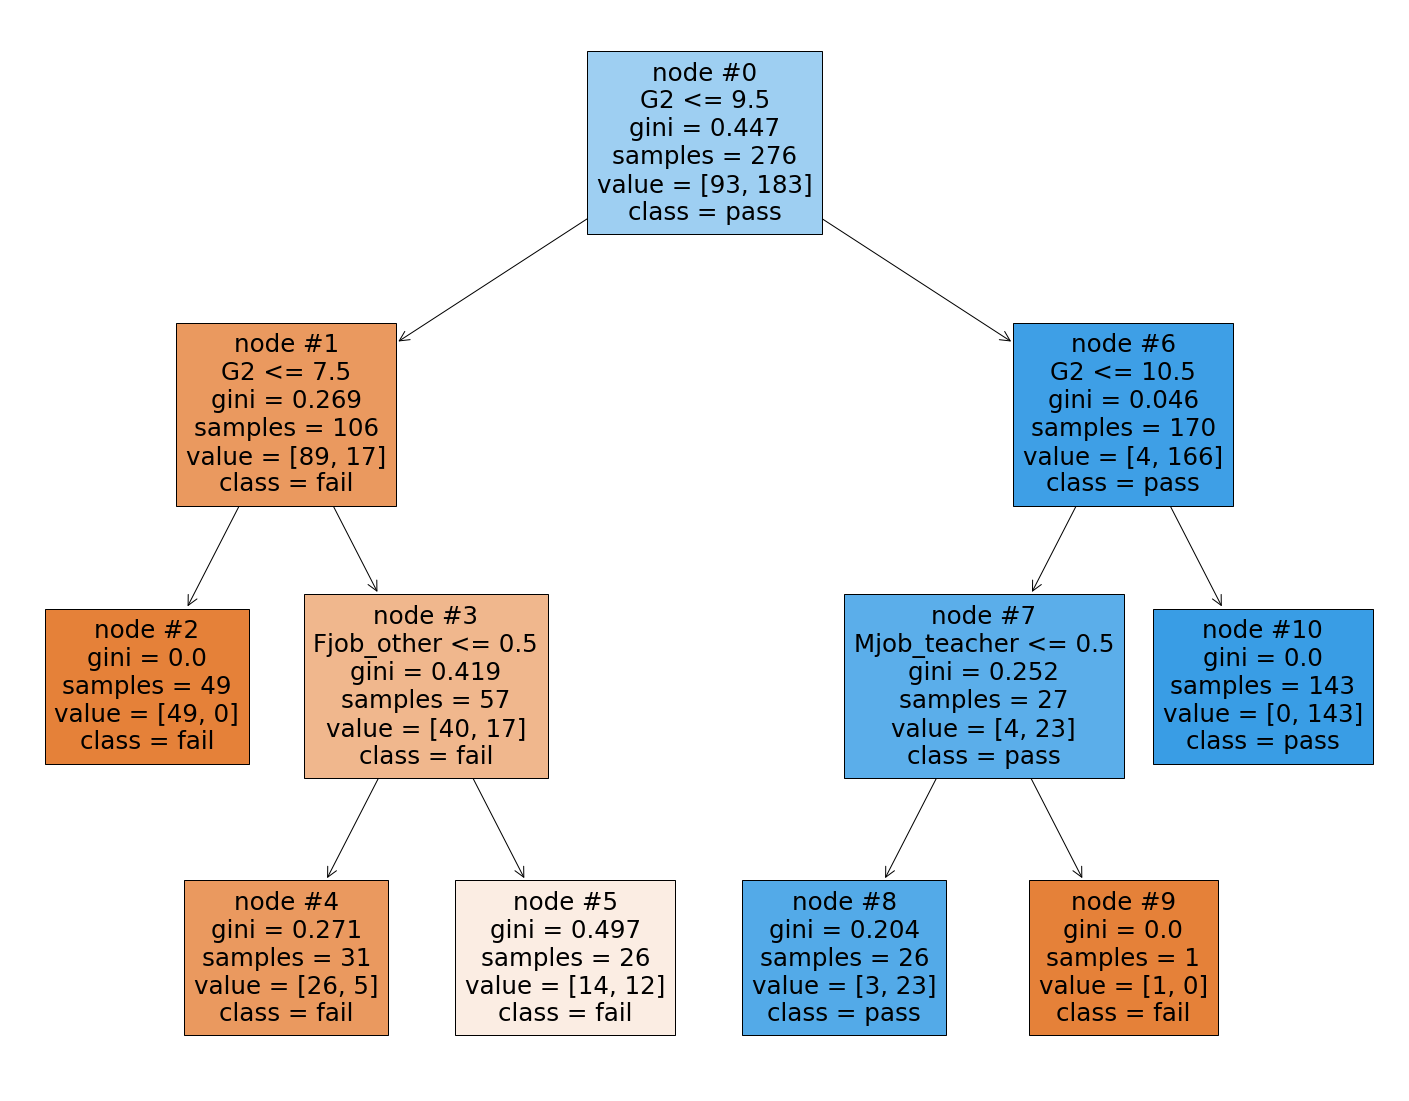

In [31]:
sample_idx = 1
X_train_Holdout, X_test_Holdout, y_train_Holdout, y_test_Holdout = train_test_split(X, y_binary, test_size=0.3, random_state=1)
X_sample = X_test_Holdout[sample_idx]
print('sample_idx:', y_test_Holdout.index[sample_idx])
print()

dTree = DecisionTreeClassifier(max_depth=3)
dTree.fit(X_train_Holdout, y_train_Holdout)
print_decision_path(dTree, X_test_Holdout, sample_idx)

# plot the decision tree
fig = plt.figure(figsize=(25,20))
tree.plot_tree(dTree, feature_names=features_dummies,  
       class_names=['fail', 'pass'],
       filled=True, node_ids=True)
print("Result:", lable_binary[(dTree.predict([X_sample]))[0]])

### Random Forest
> Describe the difference between boosting and bagging.
- Boosting
    - Multiply the error data of the previous estimator by a weight, and then train the new estimator, which means that the estimators are related.
    - When there is more noisy data, it is relatively affected, so it is less stable.
    - The weights of estimators are different.
- Bagging
    - Estimators are built independently.
    - When there is more noisy data, it is relatively unaffected, so it is more stable.
    - The weights of estimators are same.

### KNN
> Show the prediction and reasoning of one arbitrary sample in the testing set.

In [32]:
pca = PCA(n_components=2)
pca.fit(X)
X_2d = pca.transform(X)

In [33]:
X_train_Holdout, X_test_Holdout, y_train_Holdout, y_test_Holdout = train_test_split(X_2d, y_binary, test_size=0.3, random_state=1)
train_idx = y_train_Holdout.index
print('Index of the sample:', train_idx[1])

X_sample = X_test_Holdout[1]
print('The features of the sample(After PCA):')
display(pd.DataFrame(np.array(X_sample).reshape(1,2), index=['X_sample'], columns=['Feature 1', 'Feature 2']))

y_train_Holdout = list(y_train_Holdout)

# construct model
KNN_5 = KNeighborsClassifier(n_neighbors=5)
KNN_5.fit(X_train_Holdout, y_train_Holdout)

print('5 nearest neighbors:')

list_distance, list_idx = KNN_5.kneighbors([X_sample])
list_class = [lable_binary[y_train_Holdout[idx]] for idx in list_idx[0]]

display(pd.DataFrame([train_idx[list_idx[0]], list_distance[0], list_class], index=['index', 'distance', 'class'], columns=range(1,6)))

print('Features of neighbors:')
display(pd.DataFrame(X_2d[train_idx[list_idx[0]]], index=range(1,6), columns=['Feature 1', 'Feature 2']))
# for idx in list_idx[0]:
#     print(idx)
#     print(y_train_Holdout[idx])
y_pred = KNN_5.predict([X_sample])[0]
print('Predict', lable_binary[y_pred])

Index of the sample: 59
The features of the sample(After PCA):


,Feature 1,Feature 2
X_sample,11.338314,0.805306


5 nearest neighbors:


,1,2,3,4,5
index,309,281,225,133,270
distance,1.472678,2.065772,2.42978,2.432363,2.497374
class,Pass,Pass,Fail,Pass,Fail


Features of neighbors:


,Feature 1,Feature 2
1,12.322592,-0.290129
2,13.401583,0.906964
3,10.400955,3.046999
4,10.252442,-1.371221
5,9.494410,2.489614


Predict Pass


> Bonus: pick 2 features, draw and describe the KNN decision boundaries.

- Use PCA.
- Plot the points of previous train data.

In [34]:
def plot_decision_boundaries(X, y, model):
    model.fit(X, y)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    step = 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.2)
    pts1 = plt.scatter(X[pd.Series(y)==1, 0], X[pd.Series(y)==1, 1], c='goldenrod', alpha=1)
    pts2 = plt.scatter(X[pd.Series(y)==0, 0], X[pd.Series(y)==0, 1], c='orchid', alpha=1)
    plt.xlabel("Feature-1",fontsize=10)
    plt.ylabel("Feature-2",fontsize=10)
    plt.legend([pts1, pts2], ['pass','fail'])

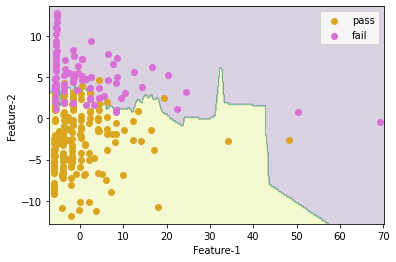

In [35]:
KNN_5 = KNeighborsClassifier(n_neighbors=9)
plot_decision_boundaries(X_train_Holdout, y_train_Holdout, KNN_5)

### PCA
> In 5-Level classification, reduce the data dimension to 2 using PCA and draw a scatter plot. You have to colorize the data points based on their labels.

In [36]:
X_2d_x = X_2d[:,0]
X_2d_y = X_2d[:,1]

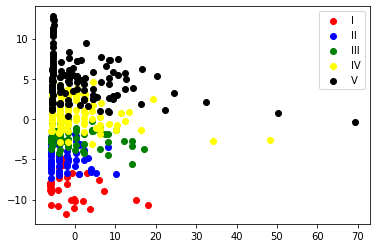

In [37]:
dict_color = {1: 'red', 2: 'blue', 3: 'green', 4: 'yellow', 5: 'black'}
dict_level = {1: 'I', 2: 'II', 3: 'III', 4: 'IV', 5: 'V'}

for level in range(1, 6):
    ix = np.where(y_level == level)
    plt.scatter(X_2d_x[ix], X_2d_y[ix], c=dict_color[level], label=dict_level[level])
plt.legend()
plt.show()